In [1]:
import pyBigWig
import pandas as pd
import sys
sys.path.append('/home/hsher/rbp-maps/maps/')
from density.ReadDensity import ReadDensity
import os
from waveform import *
from pybedtools import BedTool
import matplotlib.pyplot as plt

In [2]:
basedir = '/home/hsher/seqdata/eclip_raw/'
neg = basedir + 'ENCFF891BFD.bigWig'
pos = basedir + 'ENCFF930WRN.bigWig'
bam = basedir + 'ENCFF162FHQ.bam'
HNRNPC = ReadDensity(pos, neg, bam = bam, name = 'HNRNPC')


In [3]:
neg = basedir + 'ENCFF494CVZ.bigWig'
pos = basedir + 'ENCFF078NBU.bigWig'
bam = basedir + 'ENCFF553XCL.bam'
HNRNPK = ReadDensity(pos, neg, bam = bam, name = 'HNRNPK')

In [4]:
neg = basedir + 'ENCFF766RBQ.bigWig'
pos = basedir + 'ENCFF984MNA.bigWig'
bam = basedir + 'ENCFF959SXJ.bam'
RPS3 = ReadDensity(pos, neg, bam = bam, name = 'RPS3')

In [5]:
neg = basedir + 'ENCFF376NMQ.bigWig'
pos = basedir + 'ENCFF142OTS.bigWig'
bam = basedir + 'ENCFF896PKL.bam'
RPS11 = ReadDensity(pos, neg, bam = bam, name = 'RPS11')

# Length distribution of key transcript

In [6]:
from scipy.fft import rfft
def get_spectral(key_transcript, read_density):
    all_spect = []
    ids = []
    if len(key_transcript) < 500:
        sample = len(key_transcript)
    else:
        sample = 500
    for i in range(sample):
        chro = key_transcript[i].chrom
        start = int(key_transcript[i].start)
        end = int(key_transcript[i].stop)
        strand = key_transcript[i].strand
    
        shape = read_density.values(chro, start, end, strand)
        if np.nansum(shape) != 0:
        
            #print(chro, start, end, strand)
            if strand == '-':
                shape = [-s for s in shape]
            shape = np.nan_to_num(shape, 0)
            spect = rfft(shape/np.sum(shape))
            all_spect.append(np.abs(spect))
            ids.append((chro, start, end, strand))
            i+= 1
        else:
            i+= 1
    return all_spect, ids

In [7]:
key_transcript_hnrnpc = BedTool('/home/hsher/projects/HNRNPC.key_exon')
all_hnrnpc, id_hnrnpc = get_spectral(key_transcript_hnrnpc, HNRNPC)
key_transcript_hnrnpk = BedTool('/home/hsher/projects/HNRNPK.key_exon')
all_hnrnpk, id_hnrnpk = get_spectral(key_transcript_hnrnpk, HNRNPK)
key_transcript_rps3 = BedTool('/home/hsher/projects/RPS3.key_exon')
all_rps3, id_rps3 = get_spectral(key_transcript_rps3, RPS3)
key_transcript_rps11 = BedTool('/home/hsher/projects/RPS11.key_exon')
all_rps11, id_rps11 = get_spectral(key_transcript_rps11, RPS11)

In [14]:
min([len(a) for a in all_rps11])

23

In [15]:
stack_rps3 = np.stack([a[:20] for a in all_rps3])

In [16]:
stack_rps11 = np.stack([a[:20] for a in all_rps11])

In [17]:
stack_hnrnpk = np.stack([a[:20] for a in all_hnrnpk])

In [18]:
stack_hnrnpc = np.stack([a[:20] for a in all_hnrnpc])

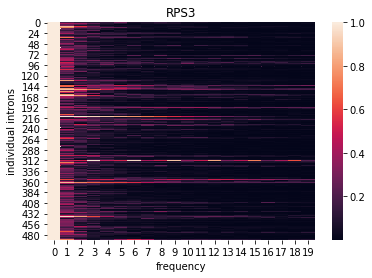

In [20]:
def plot_frequency_map(stacked,name):
    sns.heatmap(stacked)
    plt.xlabel('frequency')
    plt.ylabel('individual introns')
    plt.title(name)
plot_frequency_map(stack_rps3, 'RPS3')

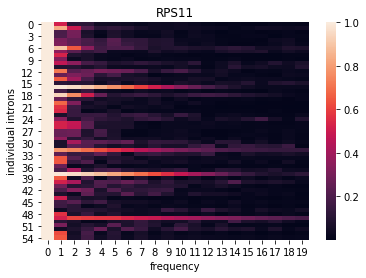

In [21]:
plot_frequency_map(stack_rps11, 'RPS11')

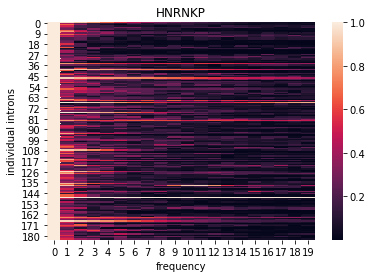

In [22]:
plot_frequency_map(stack_hnrnpk, 'HNRNKP')

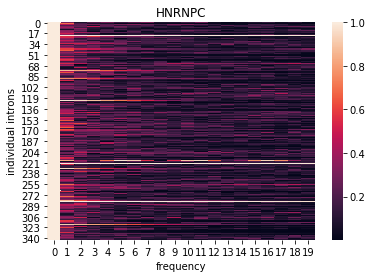

In [23]:
plot_frequency_map(stack_hnrnpc, 'HNRNPC')

In [24]:
all_pca = np.concatenate([stack_rps3, stack_rps11, stack_hnrnpk, stack_hnrnpc], axis = 0)

In [25]:
all_pca.shape

(1074, 20)

In [26]:
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced = pca.fit_transform(np.nan_to_num(all_pca,0))

In [27]:
colors = ['maroon']*stack_rps3.shape[0]+['orange']*stack_rps11.shape[0]+['navy']*stack_hnrnpk.shape[0]+['purple']*stack_hnrnpc.shape[0]

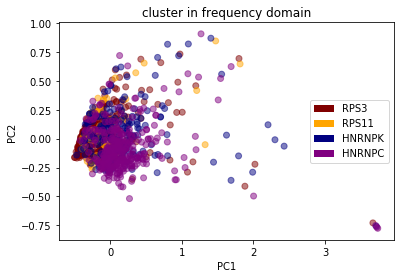

In [41]:
plt.scatter(x = reduced[:,0], y = reduced[:,1], color = colors, alpha = 0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('cluster in frequency domain')

names = ['RPS3', 'RPS11', 'HNRNPK', 'HNRNPC']
color_list = ['maroon', 'orange', 'navy', 'purple']

# make legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color_list[i], edgecolor=None,
                         label=names[i]) for i in range(4)]
plt.legend(handles=legend_elements, loc='right')

In [29]:
import numpy as np
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(np.nan_to_num(all_pca,0))


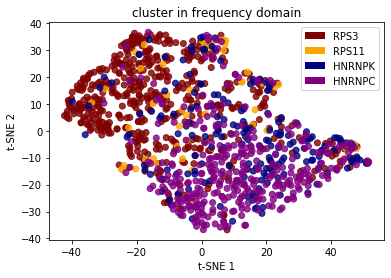

In [45]:
plt.scatter(x = X_embedded[:,0], y = X_embedded[:,1], color = colors, alpha = 0.8)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('cluster in frequency domain')
plt.legend(handles=legend_elements, loc='upper right')

In [31]:
ids = id_rps3 + id_rps11 + id_hnrnpk + id_hnrnpc

In [32]:
seq_length = [i[2]-i[1] for i in ids]

In [36]:
import matplotlib as mpl
import matplotlib.cm as cm

norm = mpl.colors.Normalize(vmin=min(seq_length), vmax=max(seq_length))
cmap = cm.Spectral

m = cm.ScalarMappable(norm=norm, cmap=cmap)
seq_length_to_color = [m.to_rgba(x) for x in seq_length]

Text(0, 0.5, 'intron length')

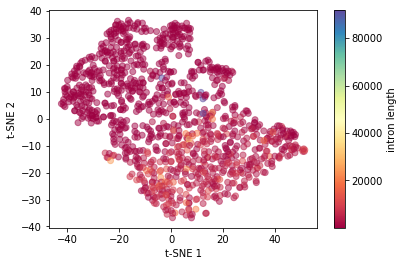

In [37]:
plt.scatter(x = X_embedded[:,0], y = X_embedded[:,1], color = seq_length_to_color, alpha = 0.5)
cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap))
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
cbar.ax.set_ylabel('intron length')

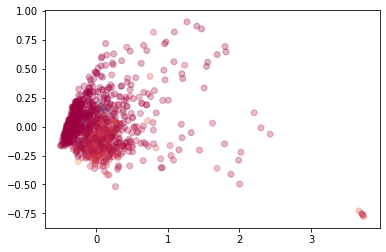

In [35]:
plt.scatter(x = reduced[:,0], y = reduced[:,1], color = seq_length_to_color, alpha = 0.3)

(array([456., 257., 166., 171., 101.,  88.,  56.,  63.,  45.,  41.,  37.,
         23.,  23.,   6.,  10.,  10.,   8.,  12.,   4.,   5.,   2.,   5.,
          3.,   2.,   3.,   2.,   3.,   2.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   2.]),
 array([7.3000000e+01, 1.0525680e+04, 2.0978360e+04, 3.1431040e+04,
        4.1883720e+04, 5.2336400e+04, 6.2789080e+04, 7.3241760e+04,
        8.3694440e+04, 9.4147120e+04, 1.0459980e+05, 1.1505248e+05,
        1.2550516e+05, 1.3595784e+05, 1.4641052e+05, 1.5686320e+05,
        1.6731588e+05, 1.7776856e+05, 1.8822124e+05, 1.9867392e+05,
        2.0912660e+05, 2.1957928e+05, 2.3003196e+05, 2.4048464e+05,
        2.5093732e+05, 2.6139000e+05, 2.7184268e+05, 2.8229536e+05,
        2.9274804e+05, 3.0320072e+05, 3.1365340e+05, 3.2410608e+05,
        3.3455876e+05, 3.4501144e+05, 3.5546412e+05, 3.6591680e+05,
        3.7636948e+05, 3.8682216e+05, 3.972748

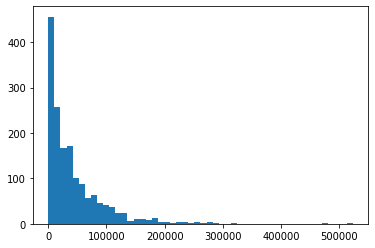

In [32]:
plt.hist(seq_length, bins = 50)

# normalize

In [46]:
all_norm = all_pca/all_pca.mean(axis =1).reshape(-1,1)

In [47]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(np.nan_to_num(all_norm,0))

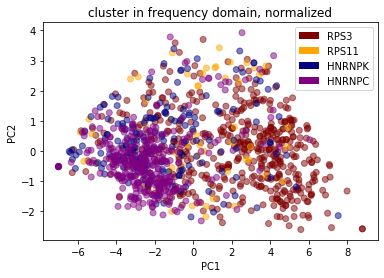

In [53]:
plt.scatter(x = reduced[:,0], y = reduced[:,1], color = colors, alpha = 0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('cluster in frequency domain, normalized')
plt.legend(handles=legend_elements, loc='upper right')

In [49]:
X_embedded = TSNE(n_components=2).fit_transform(np.nan_to_num(all_norm,0))

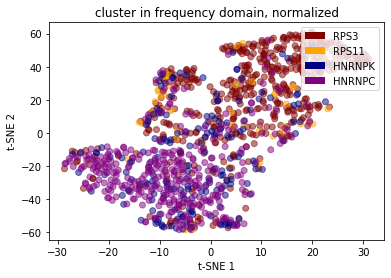

In [54]:
plt.scatter(x = X_embedded[:,0], y = X_embedded[:,1], color = colors, alpha = 0.5)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('cluster in frequency domain, normalized')
plt.legend(handles=legend_elements, loc='upper right')